In [1]:
# %pip install pandas numpy matplotlib seaborn rapidfuzz

In [2]:
import os
from typing import cast, Literal
from pprint import pp

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.ticker import MultipleLocator, StrMethodFormatter

import seaborn as sns

pd.set_option("display.expand_frame_repr", False)

from preprocessing import read_file, extract_filtered, SongAttributes
from utils.fuzzy_searchers import *
from utils.generic_plots import Plots
from utils.filters import Filters
from utils.extract_from_timestamp import * 
from utils.smoothen import *

In [3]:
# extract the "Spotify Extended Streaming History.zip" in a folder named data, sibling to this script

data_folder = os.path.join(os.path.abspath(''), "data")
print(data_folder)
# only reading Audio History files
files = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.startswith("Streaming_History_Audio")]
songs = [song for file in files for song in read_file(file)]

/home/divij/coding/projects/spotify-data-analysis/data


In [4]:
filters: list[SongAttributes] = ["ts", "ms_played", "master_metadata_track_name", "master_metadata_album_artist_name", "master_metadata_album_album_name", "spotify_track_uri"]
filtered = [extract_filtered(song, filters) for song in songs]

In [5]:
df = pd.DataFrame(filtered)

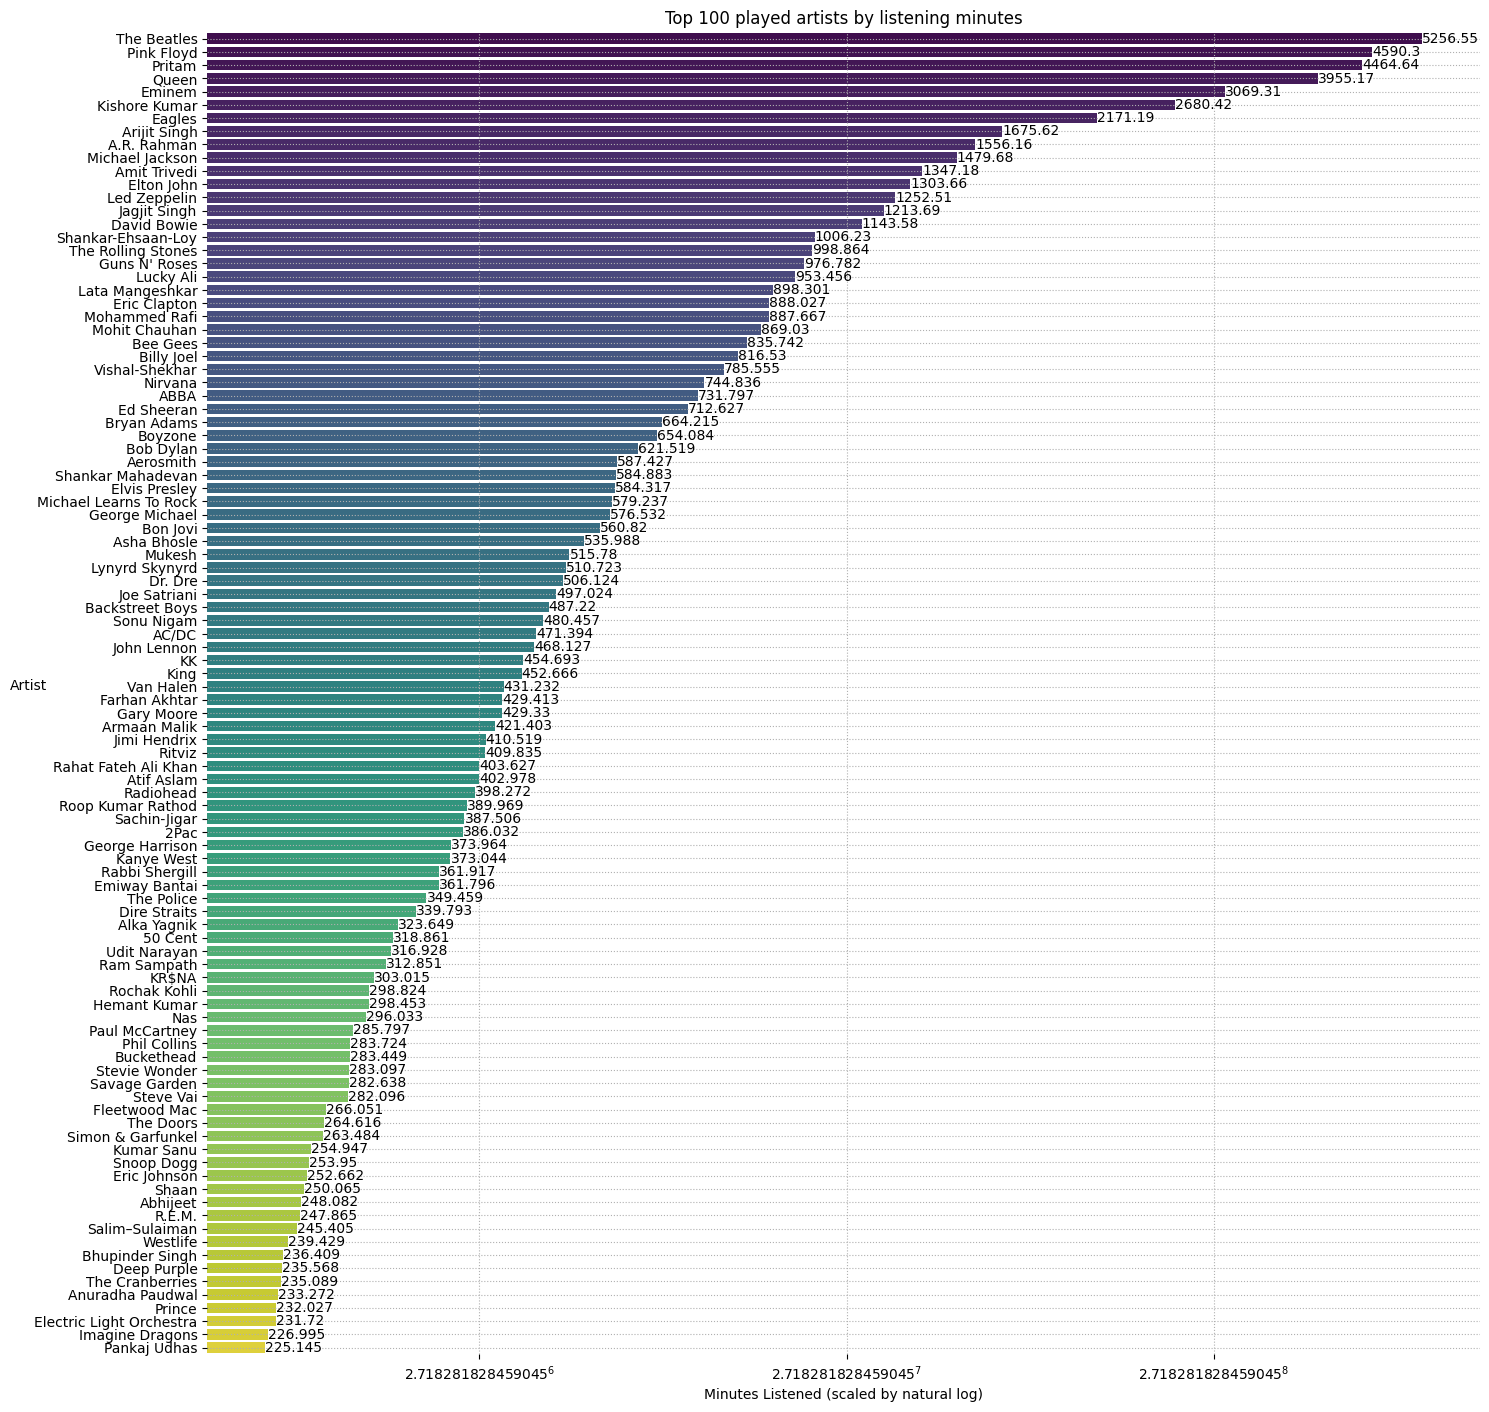

In [6]:
# Top artists by playtime
copy = df.copy(True)
grouped_by_artist_name = copy.groupby(copy["master_metadata_album_artist_name"])
time_listend = grouped_by_artist_name["ms_played"].sum()
time_listend = time_listend[time_listend != 0]
time_listend.sort_values(ascending=False, inplace=True)
time_listend_mins = time_listend.div(6e4)
time_listend_mins = cast(pd.Series, Filters.rows_gt(1, time_listend_mins))

Plots.plot_1(time_listend_mins, 100, "Top 100 played artists by listening minutes", "Minutes Listened (scaled by natural log)", "Artist")

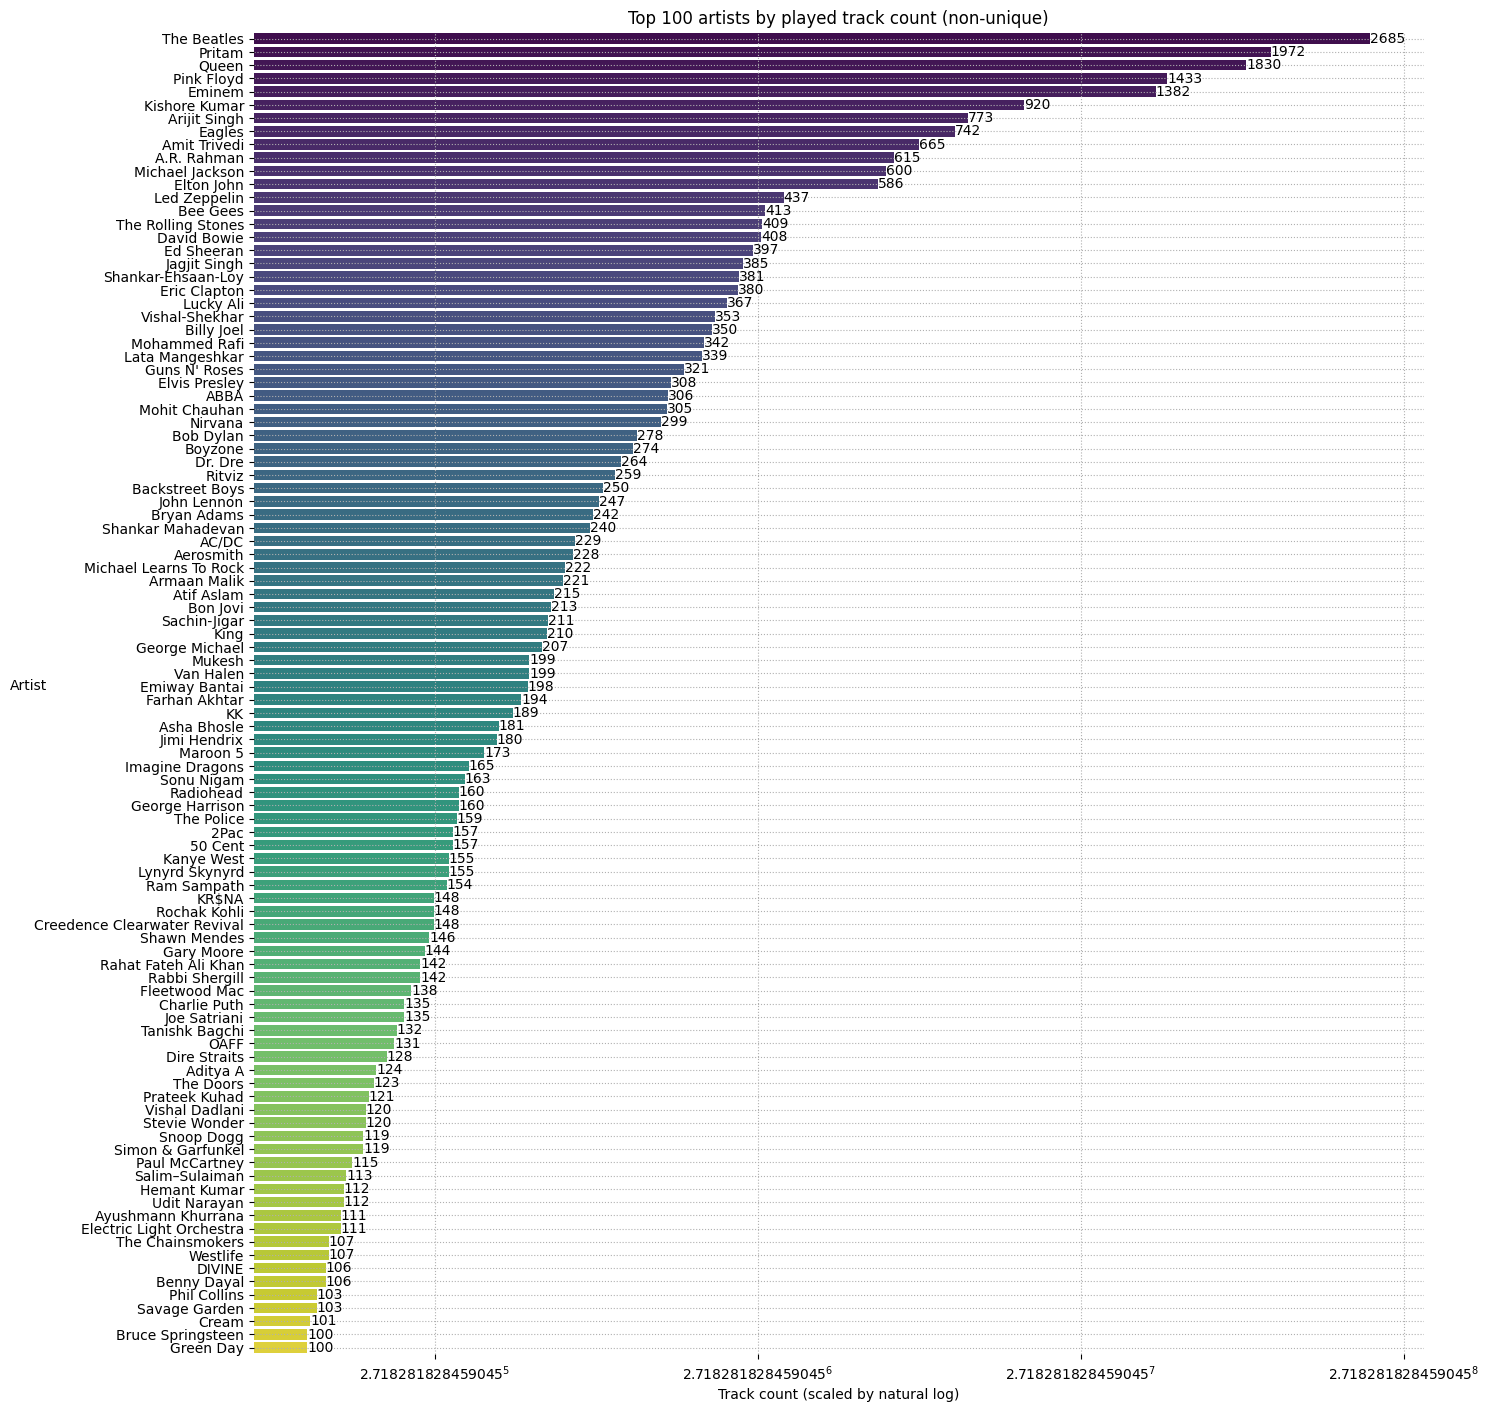

In [7]:
# Top artists by played track count
played_track_count = grouped_by_artist_name["master_metadata_album_artist_name"].count()
played_track_count.sort_values(ascending=False, inplace=True)
Plots.plot_1(played_track_count, 100, "Top 100 artists by played track count (non-unique)", "Track count (scaled by natural log)", "Artist")

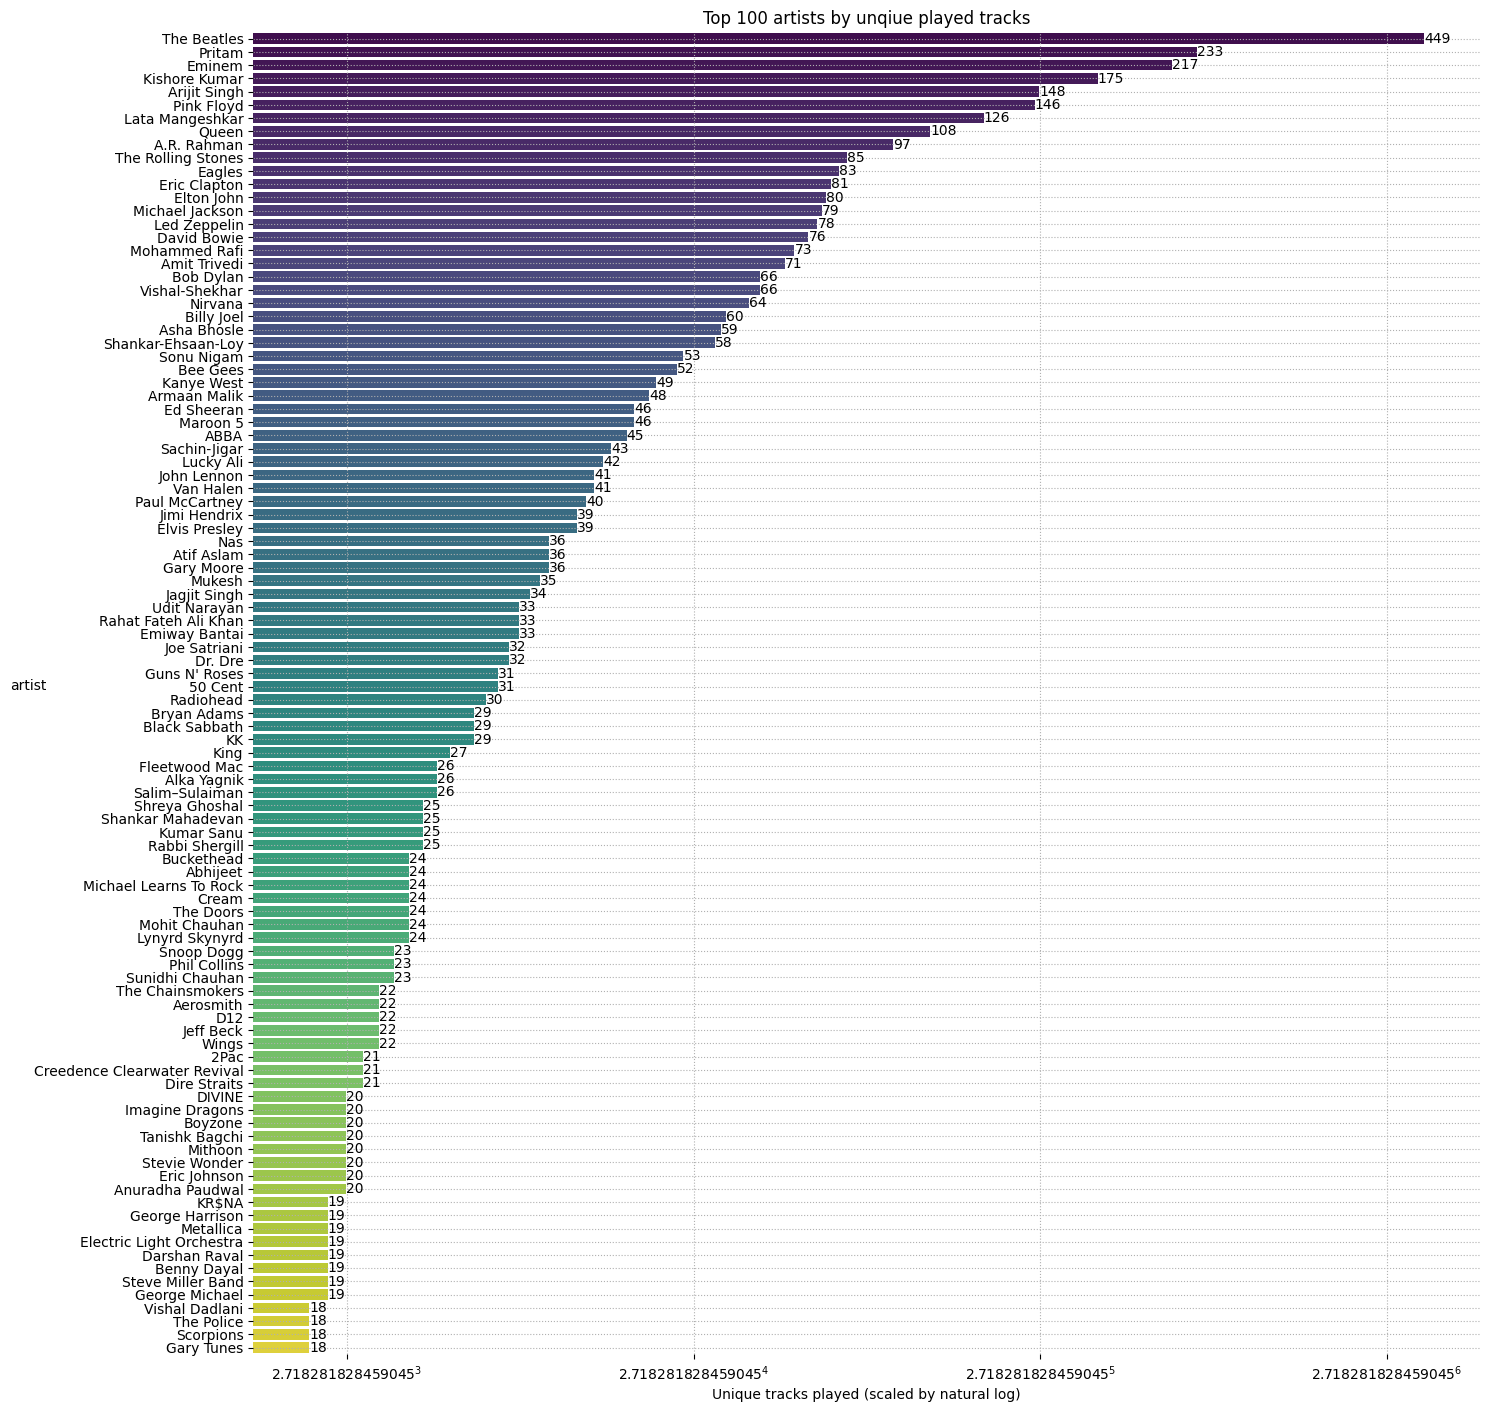

In [8]:
# select artist, distinct track_name, count(track_name) from table

unique_tracks = grouped_by_artist_name["master_metadata_track_name"].nunique()
unique_tracks.sort_values(ascending=False, inplace=True)
Plots.plot_1(unique_tracks, 100, "Top 100 artists by unqiue played tracks", "Unique tracks played (scaled by natural log)", "artist")

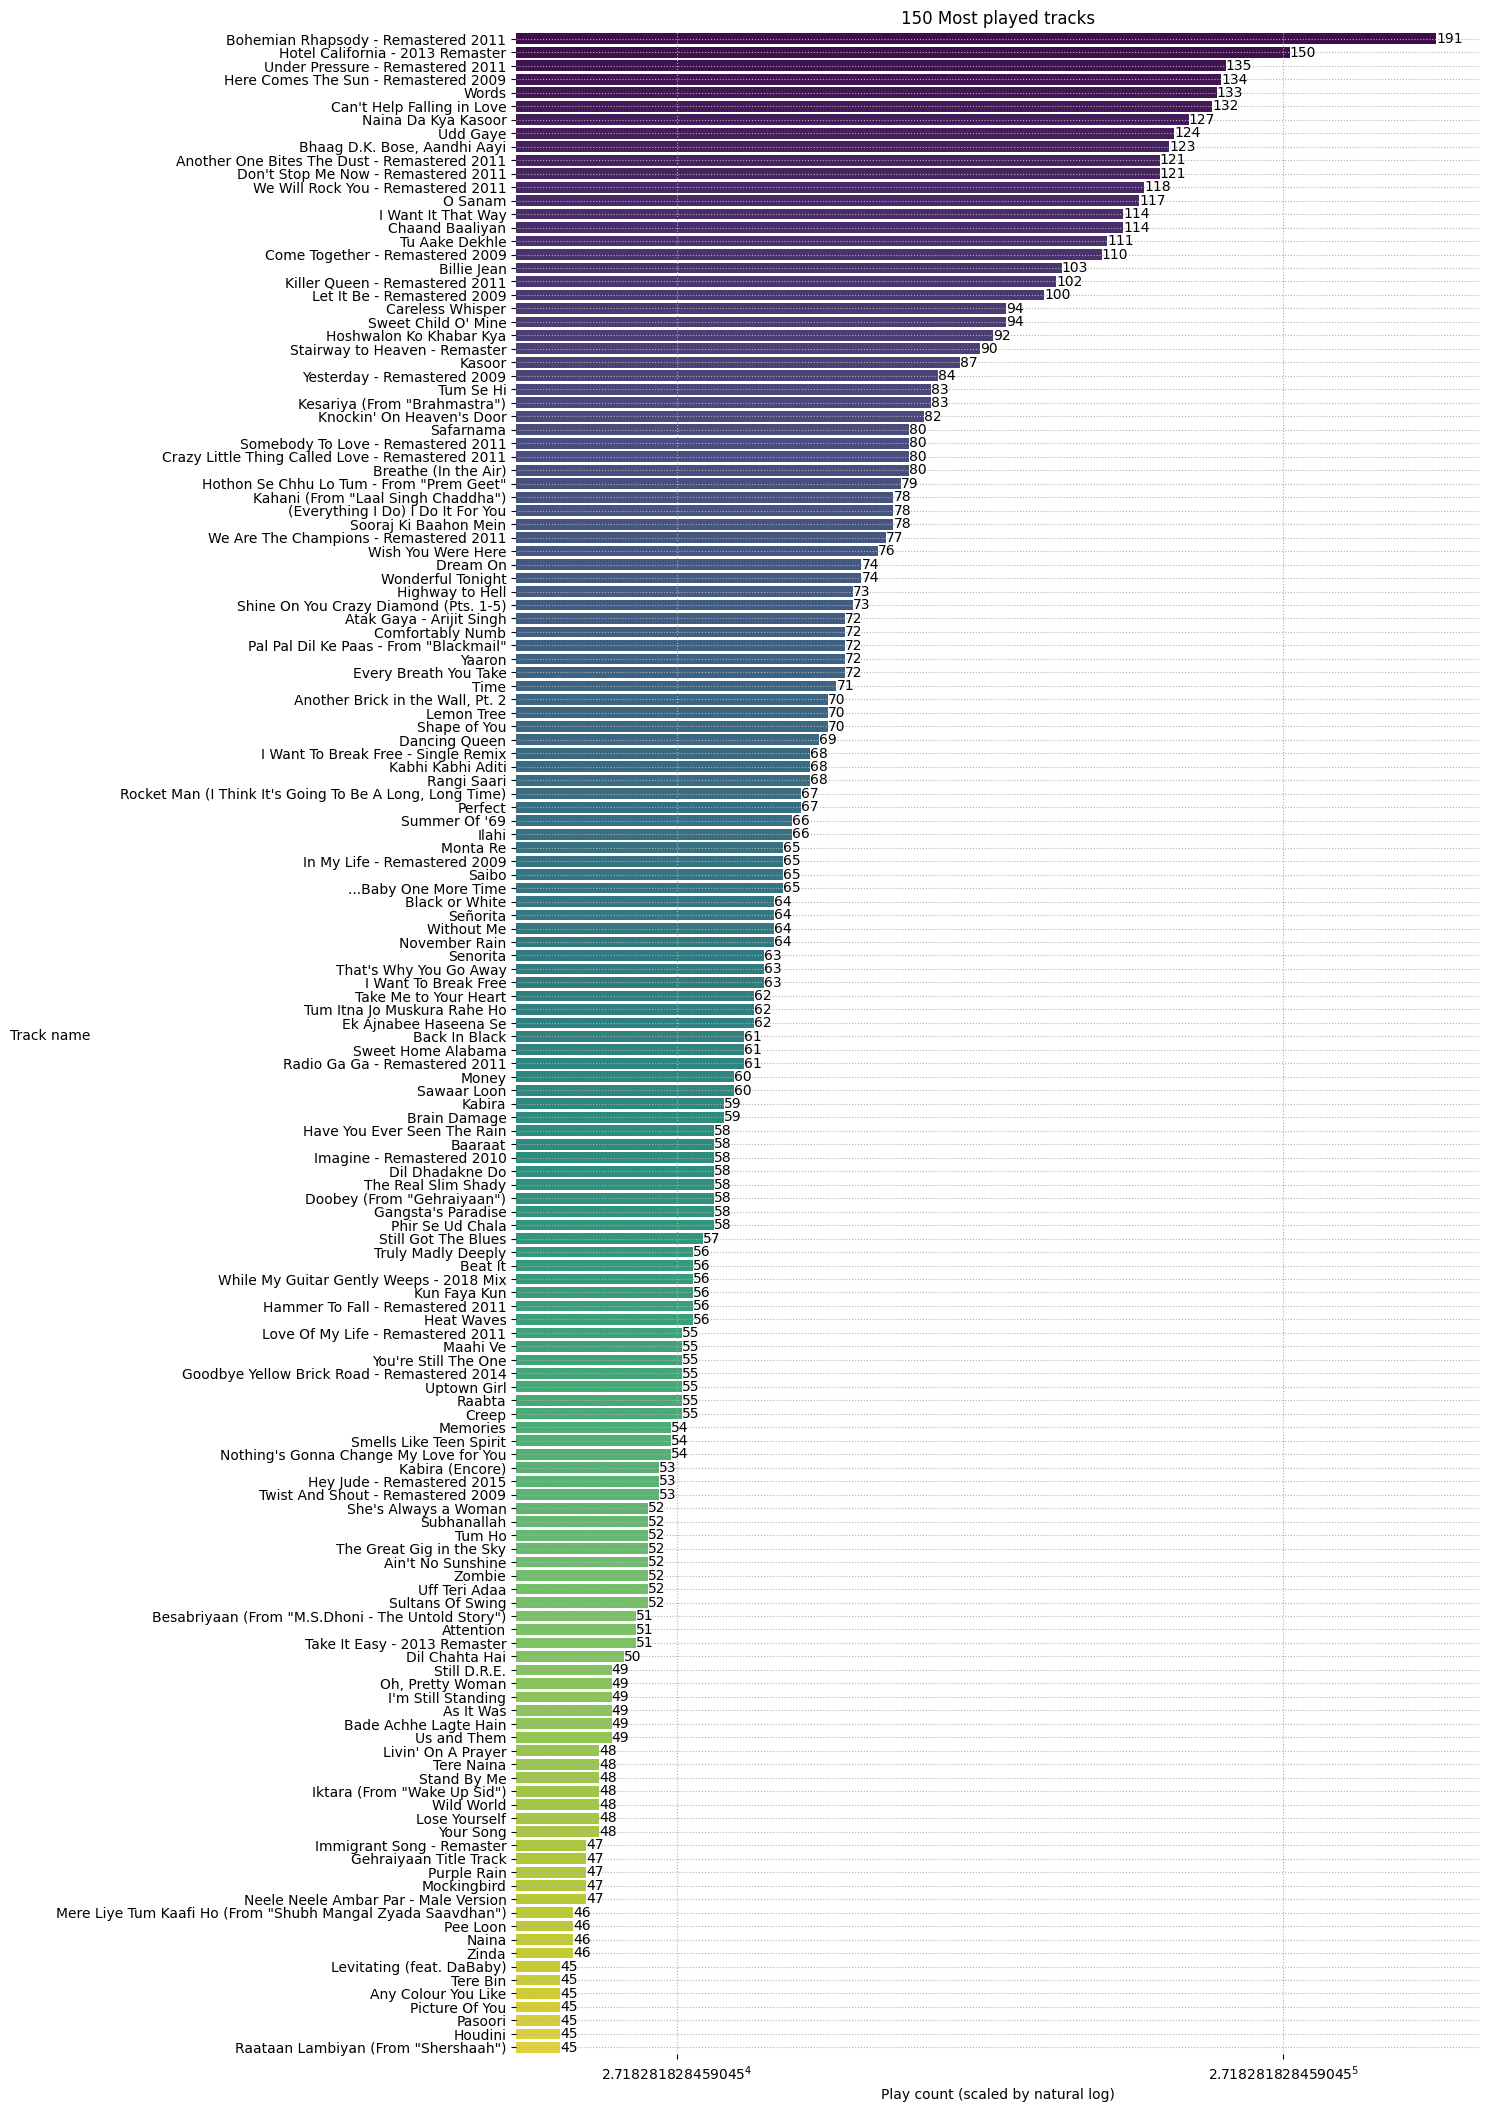

In [9]:
# Most played tracks
most_played_tracks = df.groupby(df["master_metadata_track_name"])["master_metadata_track_name"].count()
most_played_tracks.sort_values(ascending=False, inplace=True)
Plots.plot_1(most_played_tracks, 150, "150 Most played tracks", "Play count (scaled by natural log)", "Track name")


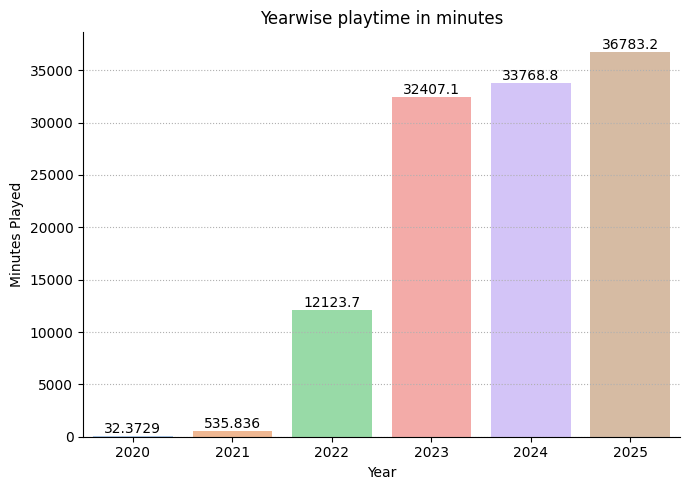

In [10]:
# yearwise listening minutes
with_dates = df.copy(True)
with_dates["ts"] = with_dates["ts"].apply(lambda ts: extract_from_timestamp("year", ts))
grouped_by_ts = with_dates.groupby("ts")
total_playtime = grouped_by_ts["ms_played"].sum()
total_playtime = total_playtime.div(6e4)
Plots.plot_2(total_playtime, "Yearwise playtime in minutes", "Year", "Minutes Played")

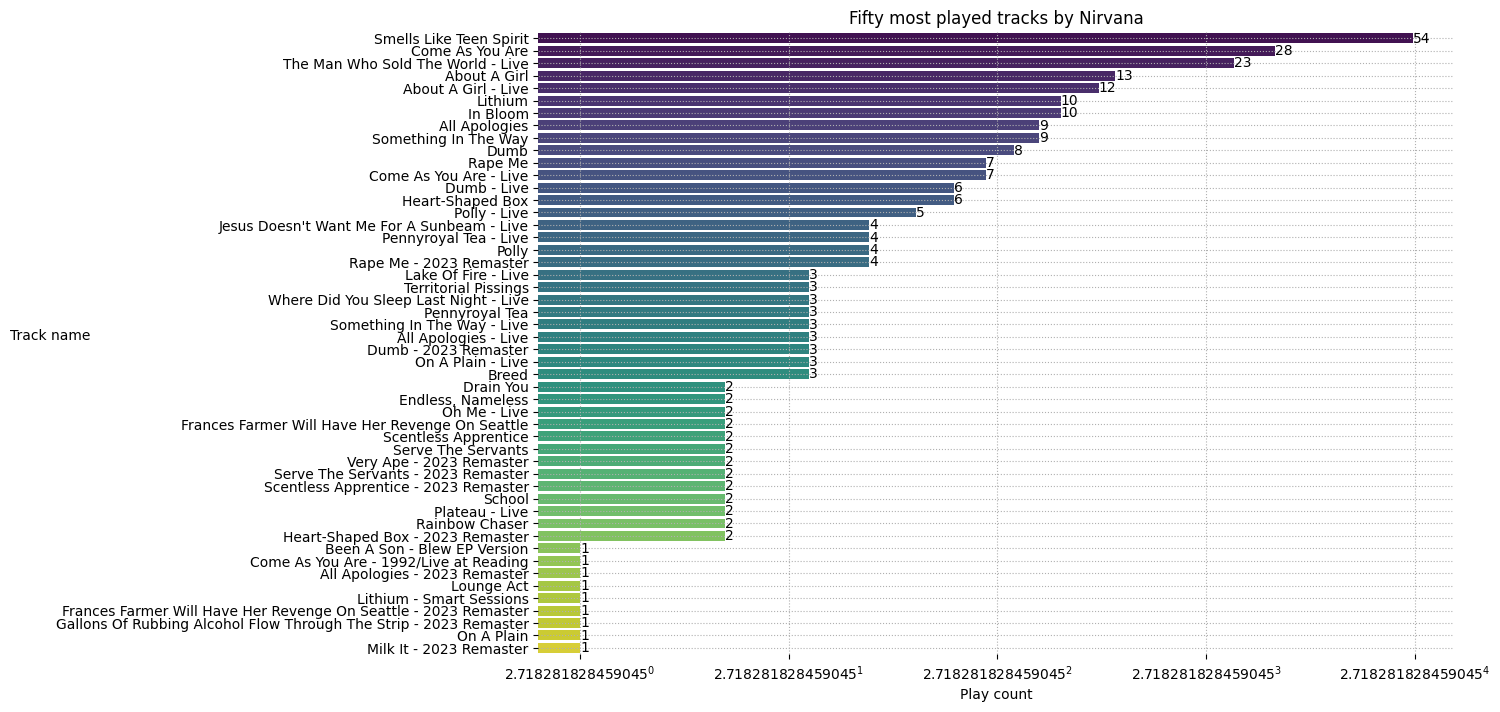

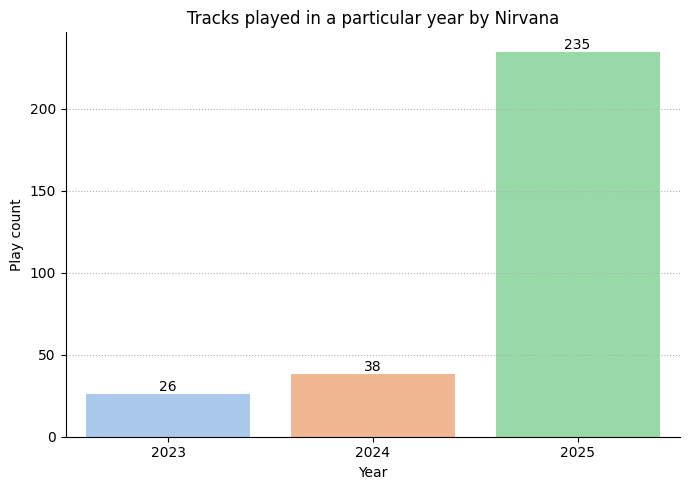

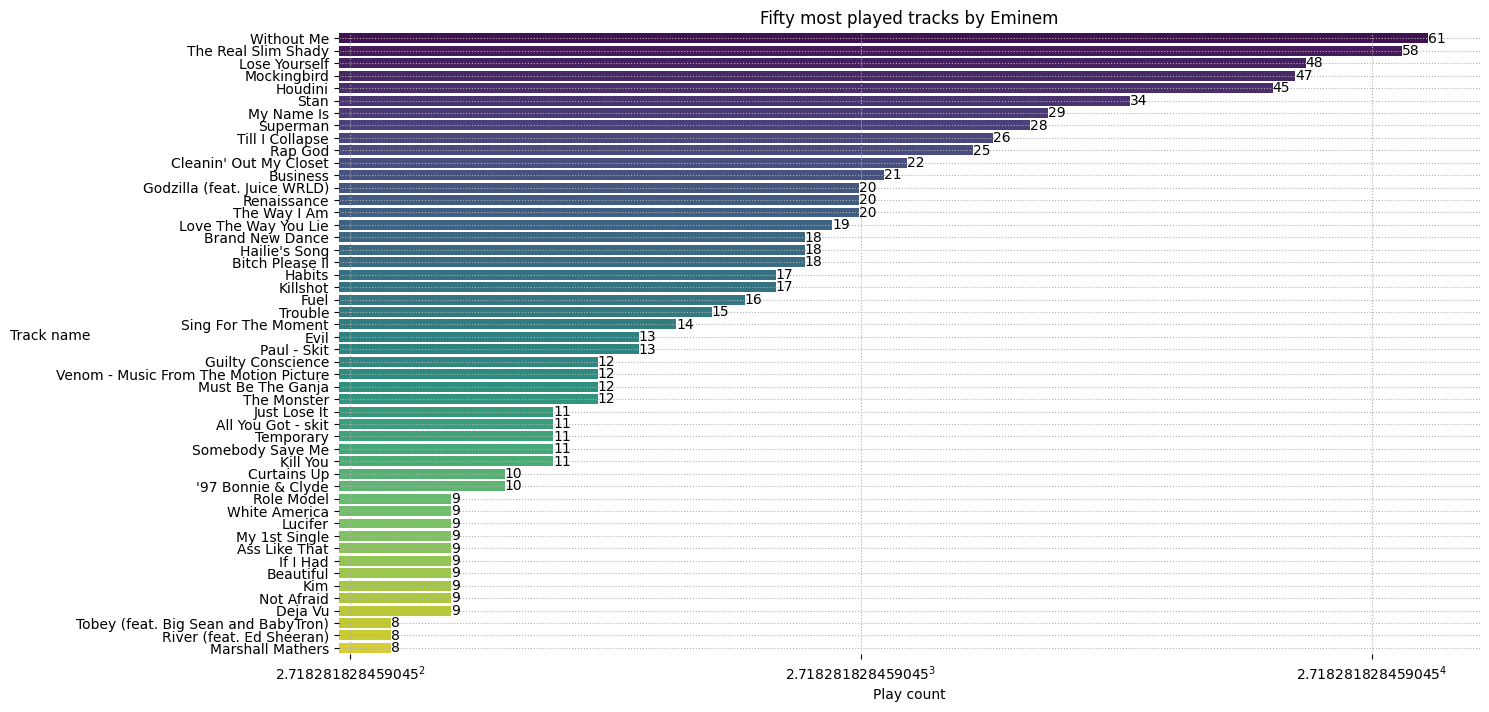

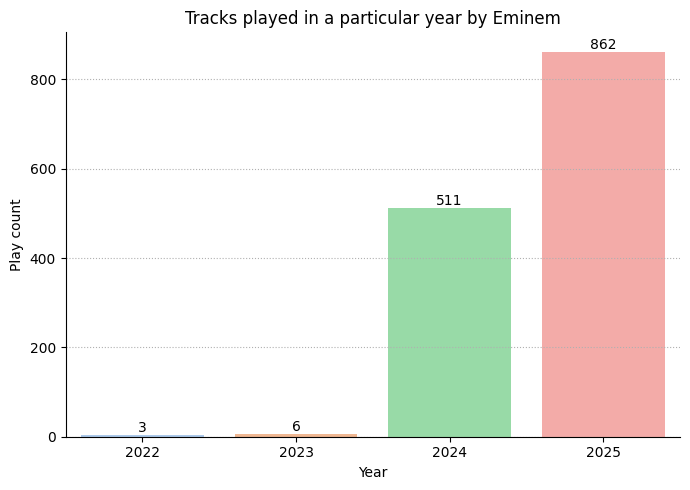

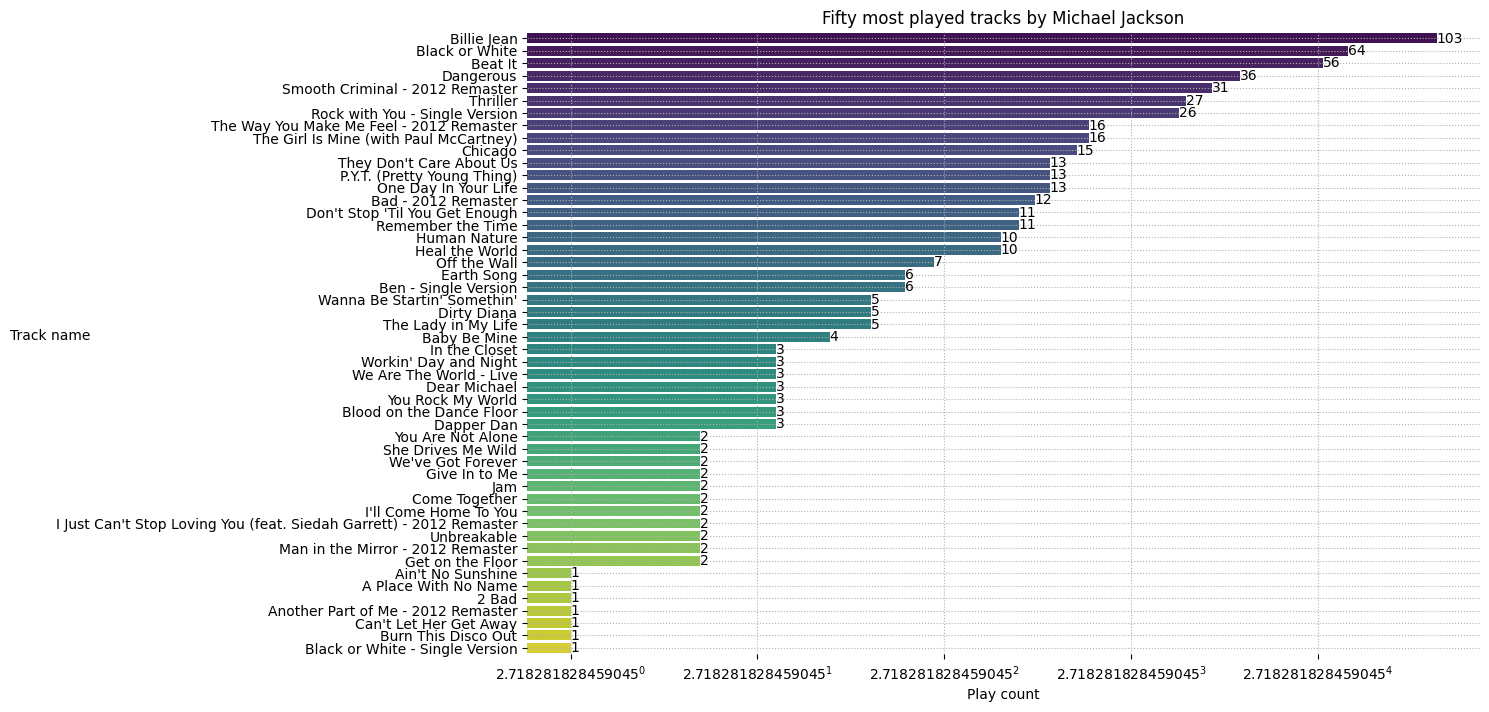

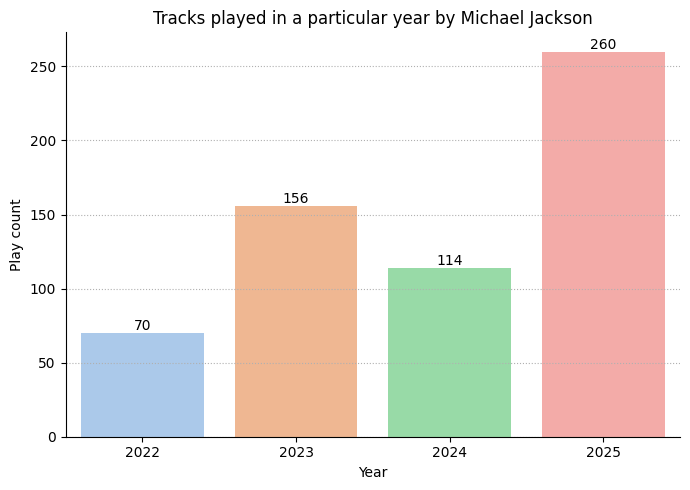

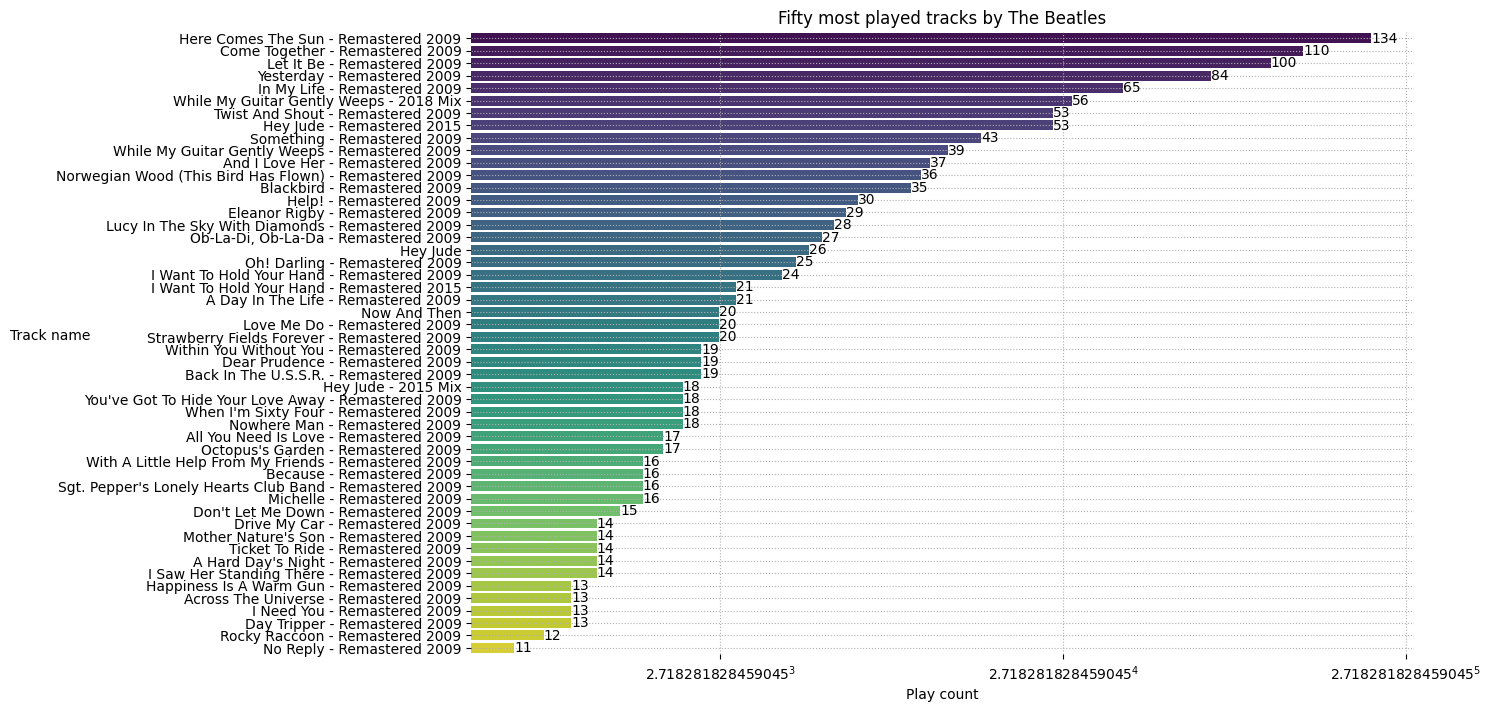

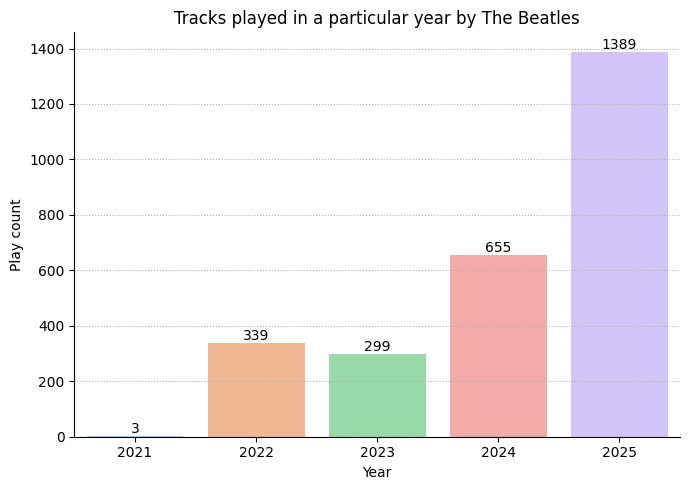

In [11]:
def analysis_per_artist(frame: pd.DataFrame, artist:str):
    if(artist not in frame["master_metadata_album_artist_name"].values):
        raise ValueError(f"Artist {artist} is not in data")

    artist_frame = frame[frame["master_metadata_album_artist_name"] == artist].copy(True)

    # grouped = artist_frame.groupby("master_metadata_album_artist_name")
    # changing ts to year
    artist_frame["year"] = artist_frame["ts"].apply(lambda ts: extract_from_timestamp("year", ts))

    # Top 50 played tracks
    played_track_count = (artist_frame
                          .groupby("master_metadata_track_name")
                          .size()
                          .sort_values(ascending=False))
    Plots.plot_1(played_track_count, 50, f"Fifty most played tracks by {artist}", "Play count", "Track name")
    
    # Year wise play time
    yearwise_playtime = (artist_frame
                         .groupby("year")
                         .size())
    Plots.plot_2(yearwise_playtime, f"Tracks played in a particular year by {artist}", "Year", "Play count")
    
    
    
analysis_per_artist(df, "Nirvana")
analysis_per_artist(df, "Eminem")
analysis_per_artist(df, "Michael Jackson")
analysis_per_artist(df, "The Beatles")

In [12]:
search_tracks("rroxxaneesa", df, 70, 10)

[]

In [13]:
search_artists("beat", df, 70, 10)

['The Beatles',
 'The Easybeats',
 'The Beatles Complete On Ukulele',
 'I Hate The Beatles',
 'The Beatles Greatest Hits Performed By The Frank Berman Band',
 'Volbeat',
 'Culture Beat',
 'Beast In Black',
 'Beastie Boys',
 'bear bear & friends']

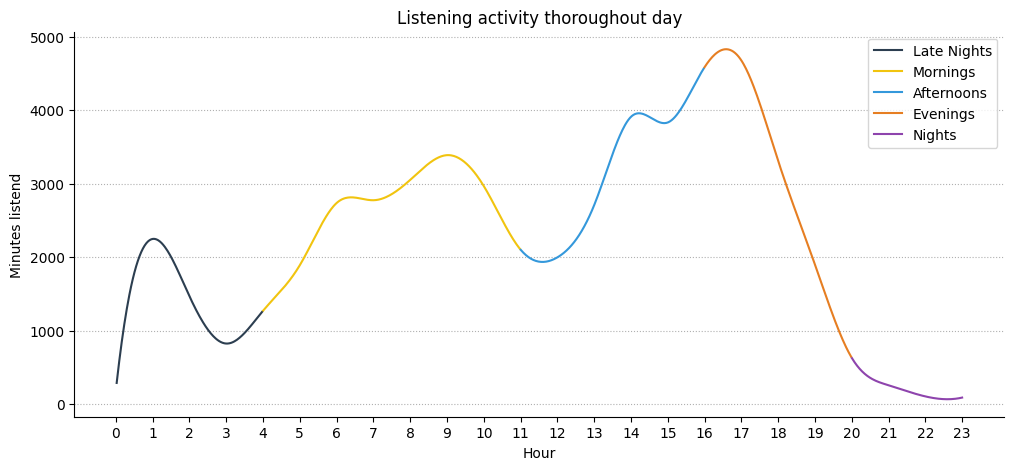

In [14]:
hour_df = df.copy(True)
hour_df["hour"] = hour_df["ts"].apply(lambda ts: extract_from_timestamp("hour", ts))
grouped = hour_df.groupby("hour")
hour_wise_count = grouped.size()
total_tracks = sum(hour_wise_count)

# late-nights = 01-04
# morning 05-11
# afternoon 12-16
# evening 17-20
# night 21-00

hour_wise_count.index = range(24) #type: ignore
smoothened = smoothen(hour_wise_count, 1000)

# daytime wise
late_nights = smoothened[(smoothened.index > 0) & (smoothened.index <=4)]
mornings = smoothened[(smoothened.index > 4) & (smoothened.index <=11)]
afternoons = smoothened[(smoothened.index > 11) & (smoothened.index <=16)]
evenings = smoothened[(smoothened.index > 16) & (smoothened.index <=20)]
nights = smoothened[(smoothened.index > 20) & (smoothened.index < 24)]

daytimes = [late_nights, mornings, afternoons, evenings, nights]
daytime_names = ["Late Nights", "Mornings", "Afternoons", "Evenings", "Nights"]
daytime_colors = ["#2c3e50", "#f1c40f", "#3498db","#e67e22","#8e44ad",]
locs = [2, 7.5, 14, 18.5, 22.5]
fig, ax = plt.subplots(1,1, figsize=(12,5))


for idx, daytime_ser in enumerate(daytimes):
    sns.lineplot(x=daytime_ser.index, y=daytime_ser.values, ax=ax, label=daytime_names[idx], color=daytime_colors[idx])
    # ax.annotate(daytime_names[idx], (locs[idx] - 1, 5000))

ax.set_xticks(range(24))
# ax.set_xticks([0, 1, 2,2.2, 3, 4, 5, 6, 7,7.5, 8, 9, 10, 11, 12, 13,13.5, 14, 15, 16, 17, 18,18.5, 19, 20, 21, 22,22.5, 23], labels=["0", "1", "2","Late Nights", "3", "4", "5", "6", "7","Mornings""", "8", "9", "10", "11", "12", "13","Afternoon", "14", "15", "16", "17", "18","Evenings", "19", "20", "21", "22","Late Nights", "23"])

# day names spread across evenly
# ax.set_xticks([2, 7.5, 14, 18.5, 22.5], labels=daytime_names)
# ax.set_xticks(np.linspace(2, 22, len(daytime_names), True), labels=daytime_names)
ax.grid(axis="y", linestyle=':')

# ax.minorticks_on()
# ax.xaxis.set_minor_locator(MultipleLocator(base=1))
# ax.xaxis.set_minor_formatter(StrMethodFormatter("{x:1.0f}"))
# ax.set_xticks(range(24), minor=True)
# ax.tick_params(direction='inout')

ax.set_xlabel("Hour")
ax.set_ylabel("Minutes listend")

ax.set_title("Listening activity thoroughout day")
sns.despine()
plt.show()

In [15]:
tracks = pd.Series(df["master_metadata_track_name"].unique())
tracks.to_json("unique_tracks.json")

In [16]:
df.loc[df.master_metadata_track_name == "Hurt"].spotify_track_uri


20360    spotify:track:28cnXtME493VX9NOw9cIUh
21214    spotify:track:28cnXtME493VX9NOw9cIUh
39480    spotify:track:28cnXtME493VX9NOw9cIUh
48277    spotify:track:28cnXtME493VX9NOw9cIUh
Name: spotify_track_uri, dtype: object

In [26]:
# FIXME: Some rows of df are nans
# Mostly all the tracks with non ascii characters
df[df.isna().any(axis=1)]

ts  ms_played master_metadata_track_name master_metadata_album_artist_name master_metadata_album_album_name spotify_track_uri
16993  2025-07-09T01:49:11Z          0                       None                              None                             None              None
16994  2025-07-09T01:49:13Z          0                       None                              None                             None              None
17029  2025-07-10T13:48:28Z          0                       None                              None                             None              None
17030  2025-07-10T13:48:30Z          0                       None                              None                             None              None
17031  2025-07-10T13:48:38Z          0                       None                              None                             None              None
...                     ...        ...                        ...                               ...                              ...               ...
36429  2023-06-12T16:43:02Z     237296                       None                              None                             None              None
36430  2023-06-12T16:48:34Z     332173                       None                              None                             None              None
36431  2023-06-12T16:57:42Z     548310                       None                              None                             None              None
36432  2023-06-13T01:07:26Z      59119                       None                              None                             None              None
36654  2023-06-15T12:37:47Z      41026                       None                              None                             None              None

[74 rows x 6 columns]

In [58]:
part = df.loc[:, ["spotify_track_uri", "master_metadata_album_album_name", "master_metadata_album_artist_name", "master_metadata_track_name"]]
# part["spotify_track_uri"] = part["spotify_track_uri"].apply(lambda id: id.split(":")[2])
# part.loc[part["spotify_track_uri"] == ]

part["spotify_track_uri"] = part["spotify_track_uri"].apply(lambda x: x.split(':')[2] if pd.notnull(x) else None)

# TODO: Find source of nan rows
part.dropna(inplace=True)
part.to_json("track-uri-name.json", orient="records")

In [61]:
part["master_metadata_track_name"].nunique() * 2

20528